In [194]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model
from keras.losses import Huber, MeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SpatialDropout1D, Input, TimeDistributed, Bidirectional
from tensorflow import keras
from keras import callbacks
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [195]:
file = pd.read_json("data.json")
data = pd.DataFrame(file['GOOG']['chart'])
data.set_index('date',inplace = True)
data = data.filter(['close'])
data_len = len(data.values)
feature = 1 

In [196]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.values)
test_size = 360 
window = 50
train_data = scaled_data[0:data_len-test_size-window,:] 
x_train = []
y_train = []
for i in range(window, len(train_data)): 
  x_train.append(train_data[i-window:i, :])
  y_train.append(train_data[i, :])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], feature))
test_data = scaled_data[data_len-(window+test_size):data_len,:]
x_test = []
y_test = []
for i in range(window, len(test_data)):
  x_test.append(test_data[i-window:i, :])
  y_test.append(test_data[i, :])

x_test,y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], feature))

In [197]:
learning_rate = 0.03
input_model = Input(shape=(window, 1))
dropout_layer = Dropout(0.2)
Dense_window = Dense(window)
Dense_feature = Dense(1)
LSTM_MODEL = Bidirectional(LSTM(30,activation='tanh'), input_shape=(x_train.shape[1], 1))
output_layer1 = LSTM_MODEL(input_model)
output_layer2 = dropout_layer(output_layer1)
output_layer3 = Dense_window(output_layer2 )
output = Dense_feature(output_layer3)
model = Model(input_model,output)
model.summary()
model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=25)

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 bidirectional_25 (Bidirecti  (None, 60)               7680      
 onal)                                                           
                                                                 
 dropout_25 (Dropout)        (None, 60)                0         
                                                                 
 dense_50 (Dense)            (None, 50)                3050      
                                                                 
 dense_51 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,781
Trainable params: 10,781
Non-trainable params: 0
______________________________________________________

In [198]:
predictions = model.predict(x_test)
print('r2_score: ',r2_score(y_test, predictions))
print('MAPE: ',mean_absolute_percentage_error(y_test, predictions))
print('MAE: ', mean_absolute_error(y_test, predictions))
print('MSE: ', mean_squared_error(y_test, predictions,squared=True))
print('rmse: ',mean_squared_error(y_test, predictions,squared=False))
predictions = scaler.inverse_transform(predictions)

12/12 [==============================] - 1s 4ms/step
r2_score:  0.9480760128452579
MAPE:  0.07523715090966908
MAE:  0.08269676709599162
MSE:  0.01077391990605746
rmse:  0.10379749470029351


C:\Users\lawre\AppData\Local\Temp\ipykernel_29092\2030919235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions[:,0]


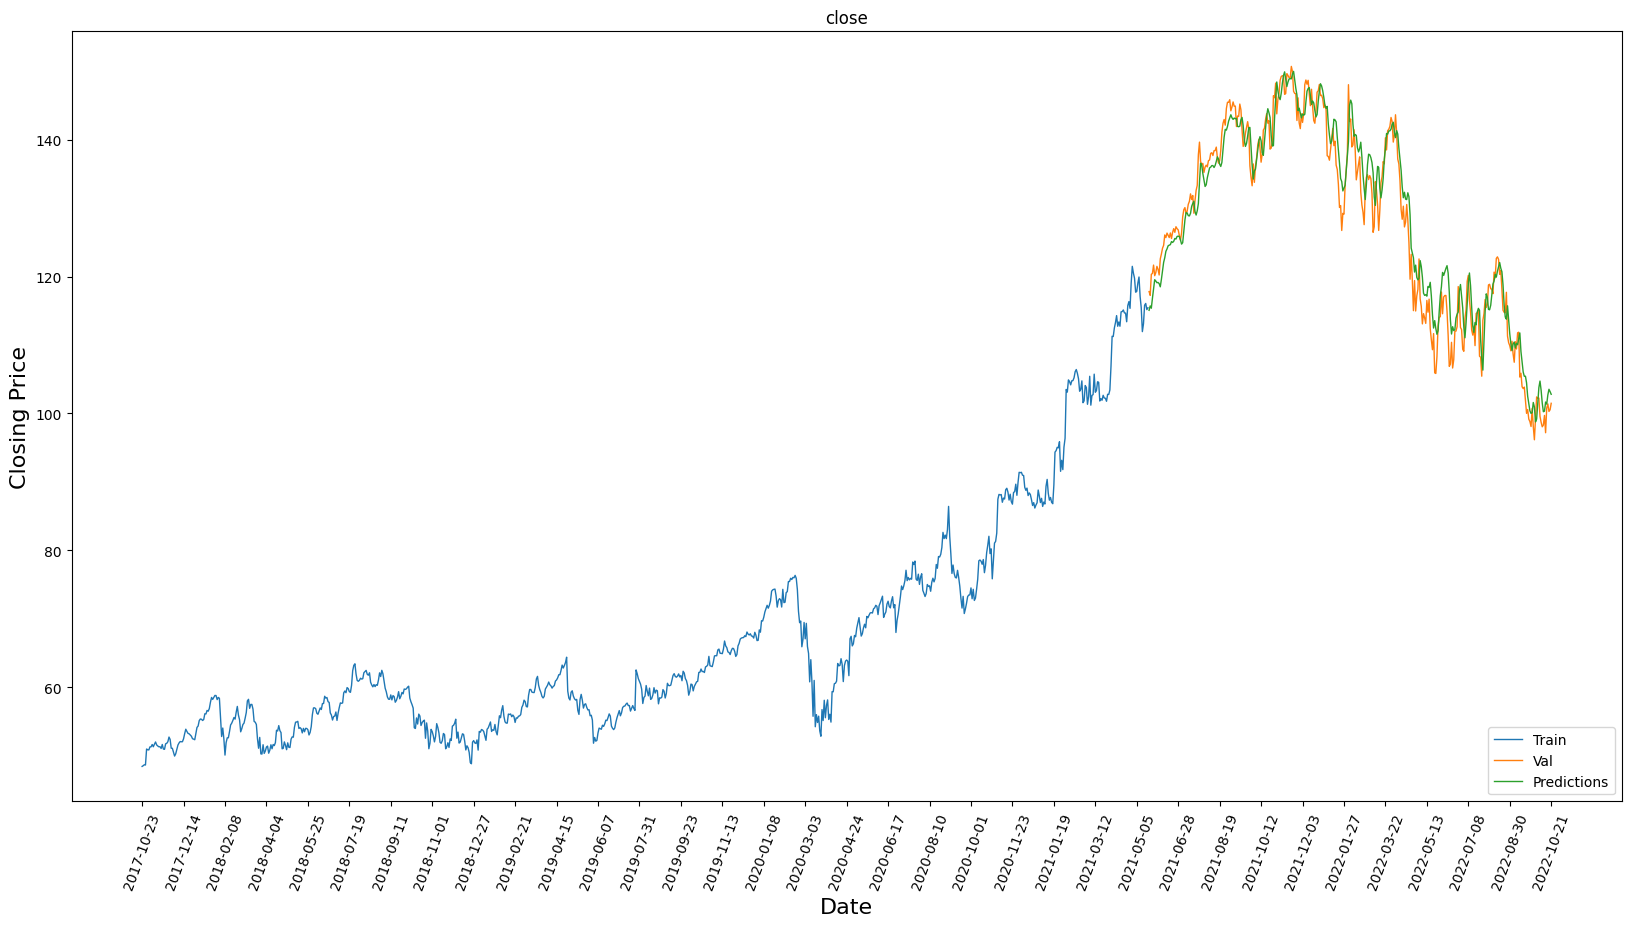

In [199]:
import indicator as indi
train = data[:data_len-test_size]
test = data[data_len-test_size:data_len]
test['Predictions'] = predictions[:,0]

plt.figure(figsize=(20,10))
plt.title('close')
plt.xlabel('Date', fontsize = 16 )
plt.ylabel('Closing Price', fontsize = 16 )
plt.plot(train['close'],linewidth=1)
plt.plot(test[['close','Predictions']],linewidth=1)
plt.xticks(np.arange(0, len(data.values)+1,37),rotation=70)
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

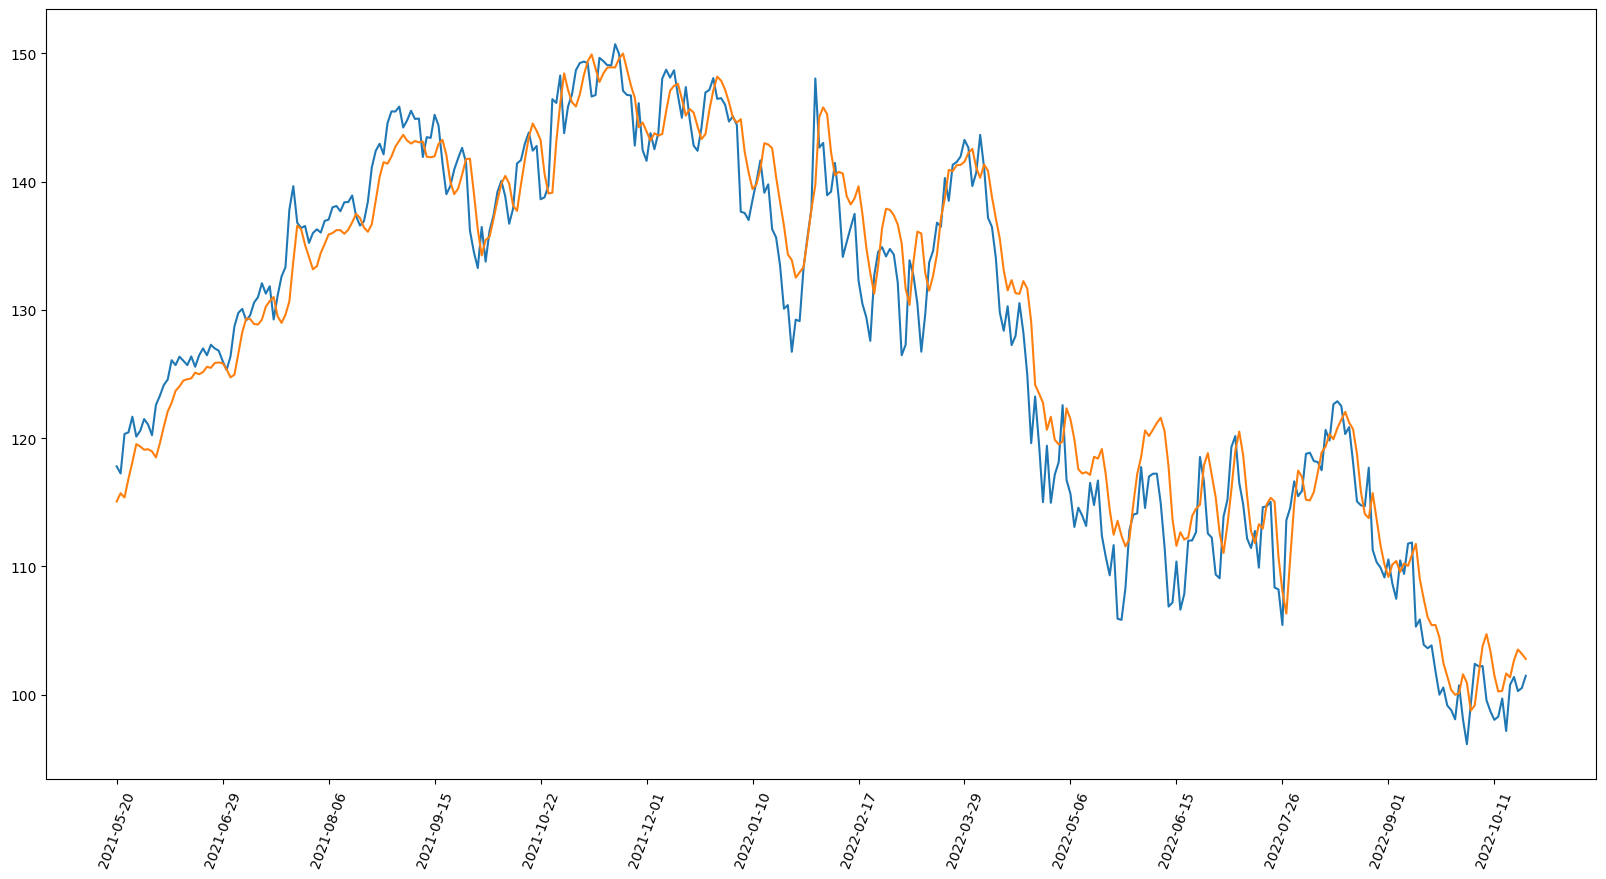

In [200]:
plt.figure(figsize=(20,10))
plt.xticks(np.arange(0, len(test)+1,27),rotation=70)
plt.plot(test[['close','Predictions']],linewidth=1.5)